# 6.6 Task

## Imports

In [1]:
# Importing libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configuure API Key

quandl.ApiConfig.api_key = 'JgwgV4yEaxTi3h8D5DkV'

In [7]:
# Importing Fed Reserve Economic Data 'Natural Rate of Unemployment' variable

data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id='99999')

In [8]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2022-05-31,604283.0
1,ZSFH,99999,2022-04-30,594699.0
2,ZSFH,99999,2022-03-31,579785.0
3,ZSFH,99999,2022-02-28,555858.0
4,ZSFH,99999,2022-01-31,539084.0


In [9]:
data.shape

(209, 4)

In [11]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [12]:
type(data)

pandas.core.frame.DataFrame

# Data Cleaning

In [16]:
# Check for nulls

data.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
dtype: int64

In [17]:
# Check for dups

dups = data.duplicated()
dups.sum()

# No dups!

0

In [18]:
# Check range of date

data['date'].min()

Timestamp('2005-01-31 00:00:00')

In [19]:
data['date'].max()

Timestamp('2022-05-31 00:00:00')

## No changes need to be made for the date range

<AxesSubplot:xlabel='value', ylabel='Density'>

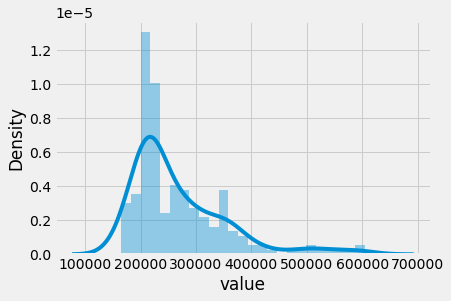

In [22]:
# Check price for extreme values

sns.distplot(data['value'], bins = 25)

## Ranges from about 200,000 to 7,000,000. Smaller skew than original dataset so I will leave it alone.

# Create subframe

In [54]:
sub = data.drop(columns = ['indicator_id'])

In [55]:
sub = data.drop(columns = ['region_id'])

In [56]:
sub.head()

,indicator_id,date,value
None,,,
0,ZSFH,2022-05-31,604283.0
1,ZSFH,2022-04-30,594699.0
2,ZSFH,2022-03-31,579785.0
3,ZSFH,2022-02-28,555858.0
4,ZSFH,2022-01-31,539084.0


In [57]:
# Set the "Date" column as the index

from datetime import datetime

sub['datetime'] = pd.to_datetime(data['date']) # Create a datetime column from "Date.""
sub = sub.set_index('datetime') # Set the datetime as the index of the dataframe.
sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
sub.head()

,indicator_id,value
datetime,,
2022-05-31,ZSFH,604283.0
2022-04-30,ZSFH,594699.0
2022-03-31,ZSFH,579785.0
2022-02-28,ZSFH,555858.0
2022-01-31,ZSFH,539084.0


In [58]:
# Drop indicator_id from df

sub = sub.drop(columns = ['indicator_id'])

In [59]:
sub.head()

,value
datetime,
2022-05-31,604283.0
2022-04-30,594699.0
2022-03-31,579785.0
2022-02-28,555858.0
2022-01-31,539084.0


In [60]:
sub.shape

(209, 1)

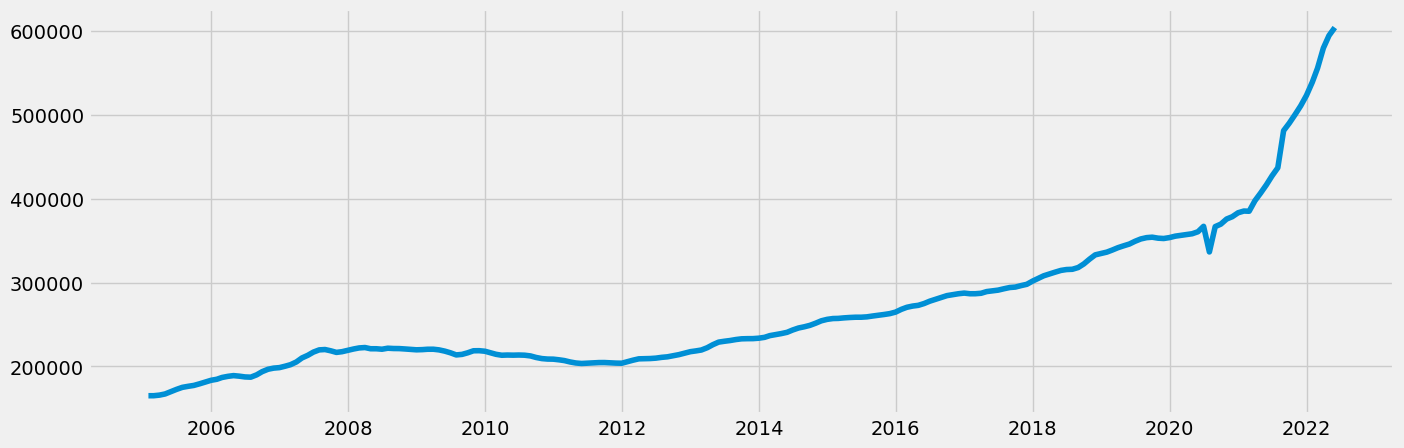

In [63]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub)

## The chart is showing an uptrend, we need to remove that before continuing our analysis.

# Decomposition

In [64]:
# Decompose time series using additive model for linear

decomposition = sm.tsa.seasonal_decompose(sub, model='additive')

In [65]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

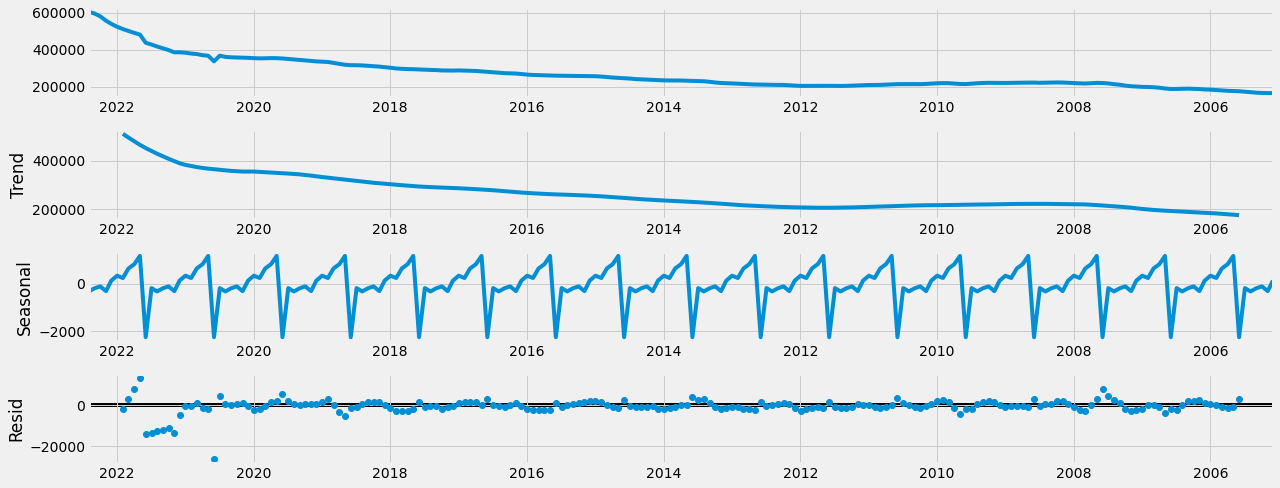

In [66]:
# Plot seperate componets

decomposition.plot()
plt.show()

In [68]:
# Conduct Dickey-Fullers Test

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.409376
p-value                          0.139108
Number of Lags Used             14.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [69]:
## The p-value is not smaller than .05 so not signifiant. Test Statistic larger than Critical Value 5% so cannot reject null hypothesis. There is a unit root. Need to get test statistic lower than critical vaule and lower p-value. 

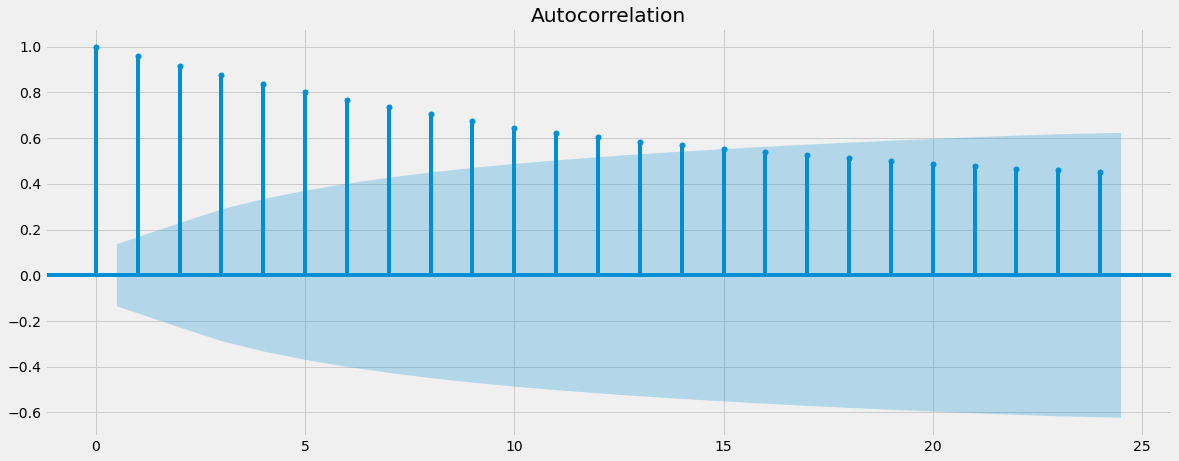

In [70]:
# PLot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(sub)
plt.show()

## Too many lags are significantly correlated

# Stationarizing Data

In [72]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff = sub - sub.shift(1)

In [73]:
# Remove missing values from differencing

data_diff.dropna(inplace = True)

In [74]:
data_diff.head()

,value
datetime,
2022-04-30,-9584.0
2022-03-31,-14914.0
2022-02-28,-23927.0
2022-01-31,-16774.0
2021-12-31,-15702.0


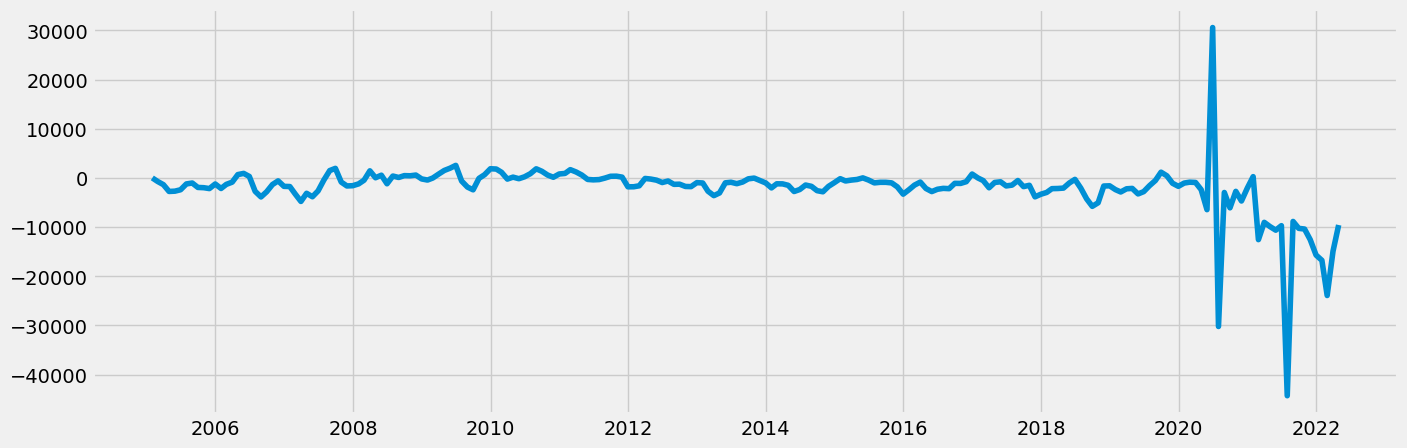

In [75]:
# Check time series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

## At first glance data looks a lot more stationary and hard to see a trend.

In [76]:
# Complete Dickey_Fuller test on new data

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.730147e+00
p-value                        3.311827e-09
Number of Lags Used            1.300000e+01
Number of Observations Used    1.940000e+02
Critical Value (1%)           -3.464515e+00
Critical Value (5%)           -2.876556e+00
Critical Value (10%)          -2.574775e+00
dtype: float64


## Now the test statistic is smaller than critical value. We can rejct null hypthoesis and this means our data is stationary. Also I think p-value is smaller than .05

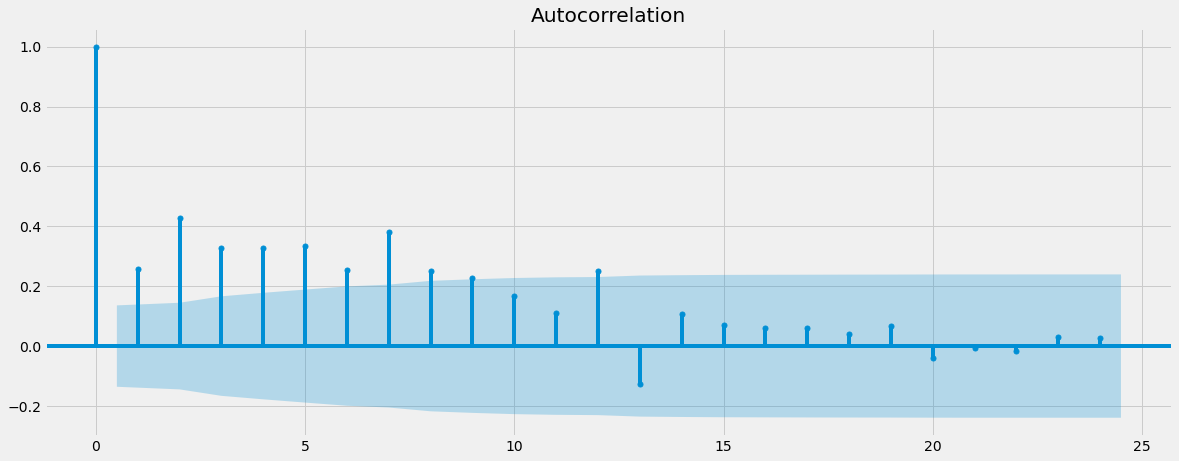

In [77]:
# Plot autocorrelations

plot_acf(data_diff)
plt.show()

## Now there are only 7 lags not in confidence intreval which is a lot better. 